# Ablation Study Analysis

This notebook generates horizontal bar charts comparing ablations against a baseline:
- Success Rate Change (%)
- Break Rate Change (%)
- Error bars showing standard deviation across seeds
- LaTeX table for ablation results

In [7]:
# ============================================================
# BLOCK 1: IMPORTS & LOCAL CONFIGURATION
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import shared utilities
from analysis_utils import (
    # Constants
    ENTITY, PROJECT,
    TAG_EVAL_PERFORMANCE,
    METRIC_SUCCESS, METRIC_BREAKS, METRIC_TOTAL,
    FONT_TITLE, FONT_AXIS_LABEL, FONT_TICK,
    DEFAULT_DPI,
    # Data functions
    get_best_checkpoint_per_run,
    download_eval_performance_data,
    filter_top_n_runs,
)

# ============================================================
# LOCAL CONFIGURATION (specific to this analysis)
# ============================================================

# Base method (full method that ablations are compared against)
BASE_CONFIG = {
    "key": "full",
    "display_name": "Full Method",
    #"tag": "LCLoP_perf-comp:2026-01-05_10:54",
    "tag": "MATCH_base-case:2026-02-04_17:46",
}

# Ablations - list of configurations to compare against base
ABLATIONS = [
    #{"key": "no_zCon", "display_name": "No Z-Contact Reward", "tag": "ablate_no-z-contact:2026-01-05_10:54"},
    #{"key": "no_ssl", "display_name": "No Supervised Selection Loss", "tag": "ablate_no-SSL:2026-01-05_10:54"},
    #{"key": "ff", "display_name": "Perfect Selection", "tag": "ablate_ff:2026-01-05_10:54"},
    #{"key": "bias_25", "display_name": "Bias 25% Force", "tag": "ablate_bias-25:2026-01-05_10:54"},
    #{"key": "bias_50", "display_name": "No Bias", "tag": "ablate_bias-50:2026-01-05_10:54"},
    #{"key": "bias_75", "display_name": "Bias 75% Force", "tag": "ablate_bias-75:2026-01-05_10:54"},
    #{"key": "bias_93", "display_name": "Bias 93% Force", "tag": "ablate_bias-93:2026-01-05_10:54"},


    {"key": "no_ssl", "display_name": "No Supervised Selection Loss", "tag": "ablate_no-SSL:2026-02-02_13:42"},
    {"key": "ff", "display_name": "Perfect Selection", "tag": "ablate_ff:2026-02-02_13:42"},
    {"key": "bias_25", "display_name": "Bias 25% Force", "tag": "ablate_bias-25:2026-02-02_13:43"},
    {"key": "bias_50", "display_name": "Bias 50% (No Bias)", "tag": "ablate_bias-50:2026-02-02_13:42"},
    {"key": "bias_75", "display_name": "Bias 75% Force", "tag": "ablate_bias-75:2026-02-02_13:43"},
    {"key": "bias_93", "display_name": "Bias 93% Force", "tag": "ablate_bias-93:2026-02-02_13:42"},
]

# Policy Selection
TOP_N_POLICIES = None
MAX_CHECKPOINT = None  # Set to int to limit checkpoint search (e.g., 2000000 for first 2M steps)

# Bar Colors (one per configuration: base + ablations)
BAR_COLORS = [
    "#1f77b4",  # Blue (base)
    "#aec7e8",  # Light blue
    "#ffbb78",  # Light orange
    "#98df8a",  # Light green
    "#ff9896",  # Light red
    "#c5b0d5",  # Light purple
    "#c49c94",  # Light brown
    "#f7b6d2",  # Light pink
]

# Plot Configuration
FIGSIZE = (8, 5)
BAR_HEIGHT = 0.6
ERROR_BAR_CAPSIZE = 3
ERROR_BAR_LINEWIDTH = 1.5

In [8]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

api = wandb.Api()
best_checkpoints = {}  # best_checkpoints[key]

# Base method
print(f"\n{'='*60}")
print(f"Base: {BASE_CONFIG['display_name']} ({BASE_CONFIG['tag']})")
print(f"{'='*60}")
best_checkpoints[BASE_CONFIG["key"]] = get_best_checkpoint_per_run(
    api, BASE_CONFIG["tag"], max_checkpoint=MAX_CHECKPOINT
)

# Ablations
for ablation in ABLATIONS:
    print(f"\n{'='*60}")
    print(f"Ablation: {ablation['display_name']} ({ablation['tag']})")
    print(f"{'='*60}")
    best_checkpoints[ablation["key"]] = get_best_checkpoint_per_run(
        api, ablation["tag"], max_checkpoint=MAX_CHECKPOINT
    )


Base: Full Method (MATCH_base-case:2026-02-04_17:46)
  Eval_performance_MATCH_base-case_f(10000)_0: best checkpoint at step 1344000 (score: 100)
  Eval_performance_MATCH_base-case_f(10000)_1: best checkpoint at step 2342400 (score: 100)
  Eval_performance_MATCH_base-case_f(10000)_2: best checkpoint at step 1996800 (score: 100)
  Eval_performance_MATCH_base-case_f(10000)_3: best checkpoint at step 1766400 (score: 100)
  Eval_performance_MATCH_base-case_f(10000)_4: best checkpoint at step 2265600 (score: 100)

Ablation: No Supervised Selection Loss (ablate_no-SSL:2026-02-02_13:42)
  Eval_performance_ablate_no-SSL_f(10000)_0: best checkpoint at step 1574400 (score: 100)
  Eval_performance_ablate_no-SSL_f(10000)_2: best checkpoint at step 1766400 (score: 100)
  Eval_performance_ablate_no-SSL_f(10000)_1: best checkpoint at step 1036800 (score: 99)
  Eval_performance_ablate_no-SSL_f(10000)_3: best checkpoint at step 1920000 (score: 97)
  Eval_performance_ablate_no-SSL_f(10000)_4: best check

In [9]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

perf_data = {}  # perf_data[key]

# Base method
print(f"\nDownloading data for Base: {BASE_CONFIG['display_name']}...")
perf_data[BASE_CONFIG["key"]] = download_eval_performance_data(
    api, BASE_CONFIG["tag"], best_checkpoints[BASE_CONFIG["key"]]
)

# Ablations
for ablation in ABLATIONS:
    print(f"Downloading data for Ablation: {ablation['display_name']}...")
    perf_data[ablation["key"]] = download_eval_performance_data(
        api, ablation["tag"], best_checkpoints[ablation["key"]]
    )

# Compute statistics for each configuration
def compute_config_stats(df, best_ckpts, top_n):
    """Compute success/break rate statistics for a configuration."""
    if df.empty:
        return {"success_mean": 0, "success_std": 0, "break_mean": 0, "break_std": 0, "n_runs": 0}
    
    if top_n is not None:
        df = filter_top_n_runs(df, best_ckpts, top_n, match_by="run_id")
    
    df = df.copy()
    df["success_rate"] = 100 * df["success"] / df["total"]
    df["break_rate"] = 100 * df["breaks"] / df["total"]
    
    return {
        "success_mean": df["success_rate"].mean(),
        "success_std": df["success_rate"].std(),
        "break_mean": df["break_rate"].mean(),
        "break_std": df["break_rate"].std(),
        "n_runs": len(df)
    }

stats = {}
all_configs = [BASE_CONFIG] + ABLATIONS
for config in all_configs:
    stats[config["key"]] = compute_config_stats(
        perf_data[config["key"]], 
        best_checkpoints[config["key"]], 
        TOP_N_POLICIES
    )

# Print summary
print("\n" + "="*60)
print("DATA SUMMARY")
print("="*60)
print(f"\nBase - {BASE_CONFIG['display_name']}:")
s = stats[BASE_CONFIG["key"]]
print(f"  Runs: {s['n_runs']}")
print(f"  Success: {s['success_mean']:.1f}% +/- {s['success_std']:.1f}%")
print(f"  Break: {s['break_mean']:.1f}% +/- {s['break_std']:.1f}%")

for ablation in ABLATIONS:
    s = stats[ablation["key"]]
    print(f"\n{ablation['display_name']}:")
    print(f"  Runs: {s['n_runs']}")
    print(f"  Success: {s['success_mean']:.1f}% +/- {s['success_std']:.1f}%")
    print(f"  Break: {s['break_mean']:.1f}% +/- {s['break_std']:.1f}%")



DATA SUMMARY

Base - Full Method:
  Runs: 5
  Success: 100.0% +/- 0.0%
  Break: 0.0% +/- 0.0%

No Supervised Selection Loss:
  Runs: 5
  Success: 99.0% +/- 1.2%
  Break: 0.0% +/- 0.0%

Perfect Selection:
  Runs: 5
  Success: 98.8% +/- 1.6%
  Break: 0.0% +/- 0.0%

Bias 25% Force:
  Runs: 5
  Success: 99.2% +/- 1.3%
  Break: 0.0% +/- 0.0%

Bias 50% (No Bias):
  Runs: 5
  Success: 99.8% +/- 0.4%
  Break: 0.0% +/- 0.0%

Bias 75% Force:
  Runs: 5
  Success: 97.6% +/- 2.7%
  Break: 0.0% +/- 0.0%

Bias 93% Force:
  Runs: 5
  Success: 98.6% +/- 1.3%
  Break: 0.0% +/- 0.0%


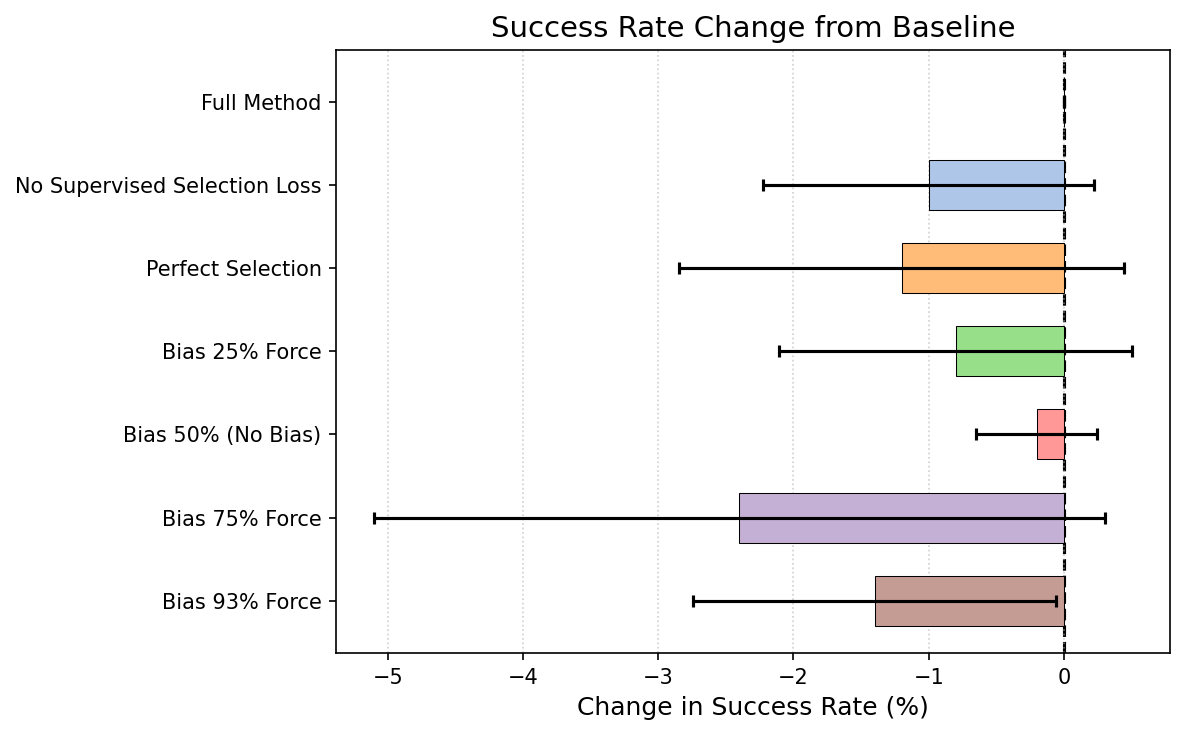

In [10]:
# ============================================================
# BLOCK 4: SUCCESS RATE ABLATION PLOT
# ============================================================

# Get baseline success rate
base_success = stats[BASE_CONFIG["key"]]["success_mean"]

# Compute percentage change from baseline for each config
display_names = []
changes = []
errors = []
colors = []

for i, config in enumerate(all_configs):
    s = stats[config["key"]]
    change = s["success_mean"] - base_success
    
    display_names.append(config["display_name"])
    changes.append(change)
    errors.append(s["success_std"])
    colors.append(BAR_COLORS[i % len(BAR_COLORS)])

# Reverse order so base is at top
display_names = display_names[::-1]
changes = changes[::-1]
errors = errors[::-1]
colors = colors[::-1]

# Create plot
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DEFAULT_DPI)
y_pos = np.arange(len(display_names))

# Draw horizontal bars
bars = ax.barh(y_pos, changes, height=BAR_HEIGHT, color=colors, edgecolor='black', linewidth=0.5)

# Add error bars
ax.errorbar(changes, y_pos, xerr=errors, fmt='none', 
            color='black', capsize=ERROR_BAR_CAPSIZE, 
            linewidth=ERROR_BAR_LINEWIDTH, capthick=ERROR_BAR_LINEWIDTH)

# Add vertical line at 0 (baseline)
ax.axvline(x=0, color='black', linewidth=1.5, linestyle='--', zorder=0)

# Configure axes
ax.set_yticks(y_pos)
ax.set_yticklabels(display_names, fontsize=FONT_TICK)
ax.set_xlabel("Change in Success Rate (%)", fontsize=FONT_AXIS_LABEL)
ax.set_title("Success Rate Change from Baseline", fontsize=FONT_TITLE)
ax.tick_params(axis='x', labelsize=FONT_TICK)
ax.xaxis.grid(True, linestyle=':', alpha=0.6)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

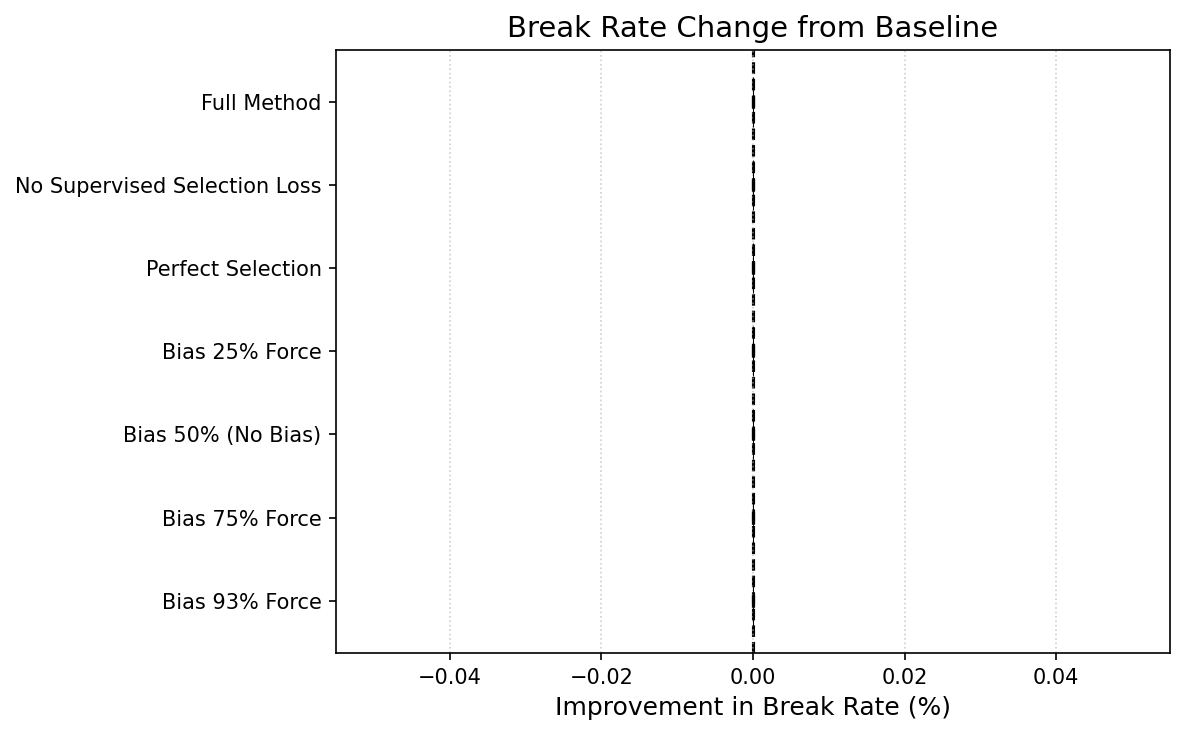

In [11]:
# ============================================================
# BLOCK 5: BREAK RATE ABLATION PLOT
# ============================================================

# Break rate direction: if True, lower break rate = positive change (improvement)
LOWER_IS_BETTER = True

# Get baseline break rate
base_break = stats[BASE_CONFIG["key"]]["break_mean"]

# Compute percentage change from baseline for each config
display_names = []
changes = []
errors = []
colors = []

for i, config in enumerate(all_configs):
    s = stats[config["key"]]
    
    if LOWER_IS_BETTER:
        change = base_break - s["break_mean"]  # Lower = positive (improvement)
    else:
        change = s["break_mean"] - base_break  # Raw direction
    
    display_names.append(config["display_name"])
    changes.append(change)
    errors.append(s["break_std"])
    colors.append(BAR_COLORS[i % len(BAR_COLORS)])

# Reverse order so base is at top
display_names = display_names[::-1]
changes = changes[::-1]
errors = errors[::-1]
colors = colors[::-1]

# Create plot
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DEFAULT_DPI)
y_pos = np.arange(len(display_names))

# Draw horizontal bars
bars = ax.barh(y_pos, changes, height=BAR_HEIGHT, color=colors, edgecolor='black', linewidth=0.5)

# Add error bars
ax.errorbar(changes, y_pos, xerr=errors, fmt='none', 
            color='black', capsize=ERROR_BAR_CAPSIZE, 
            linewidth=ERROR_BAR_LINEWIDTH, capthick=ERROR_BAR_LINEWIDTH)

# Add vertical line at 0 (baseline)
ax.axvline(x=0, color='black', linewidth=1.5, linestyle='--', zorder=0)

# Configure axes
ax.set_yticks(y_pos)
ax.set_yticklabels(display_names, fontsize=FONT_TICK)
x_label = "Improvement in Break Rate (%)" if LOWER_IS_BETTER else "Change in Break Rate (%)"
ax.set_xlabel(x_label, fontsize=FONT_AXIS_LABEL)
ax.set_title("Break Rate Change from Baseline", fontsize=FONT_TITLE)
ax.tick_params(axis='x', labelsize=FONT_TICK)
ax.xaxis.grid(True, linestyle=':', alpha=0.6)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [12]:
# ============================================================
# BLOCK 6: LATEX TABLE - ABLATION RESULTS
# ============================================================

# Table Configuration
TABLE_CAPTION = "Ablation study results. Best performance per metric in \\textbf{bold}."
TABLE_LABEL = "tab:ablation"
DECIMAL_PLACES = 1

def format_mean_std(mean, std, decimal=1):
    return f"{mean:.{decimal}f} $\\pm$ {std:.{decimal}f}"

def bold_if_best(value_str, is_best):
    if is_best:
        return f"\\textbf{{{value_str}}}"
    return value_str

# Find best values
best_success = max(stats[c["key"]]["success_mean"] for c in all_configs)
best_break = min(stats[c["key"]]["break_mean"] for c in all_configs)

# Generate LaTeX
UP_ARROW = "$\\uparrow$"
DOWN_ARROW = "$\\downarrow$"

latex_lines = [
    "\\begin{table}[t]",
    "\\centering",
    f"\\caption{{{TABLE_CAPTION}}}",
    f"\\label{{{TABLE_LABEL}}}",
    "\\begin{tabular}{lcc}",
    "\\toprule",
    f"Configuration & Success {UP_ARROW} & Break {DOWN_ARROW} \\\\",
    "\\midrule",
]

for config in all_configs:
    s = stats[config["key"]]
    
    success_str = format_mean_std(s["success_mean"], s["success_std"], DECIMAL_PLACES)
    break_str = format_mean_std(s["break_mean"], s["break_std"], DECIMAL_PLACES)
    
    is_best_success = abs(s["success_mean"] - best_success) < 0.01
    is_best_break = abs(s["break_mean"] - best_break) < 0.01
    
    success_str = bold_if_best(success_str, is_best_success)
    break_str = bold_if_best(break_str, is_best_break)
    
    latex_lines.append(f"{config['display_name']} & {success_str} & {break_str} \\\\")

latex_lines.extend([
    "\\bottomrule",
    "\\end{tabular}",
    "\\end{table}",
])

latex_output = "\n".join(latex_lines)
print(latex_output)

\begin{table}[t]
\centering
\caption{Ablation study results. Best performance per metric in \textbf{bold}.}
\label{tab:ablation}
\begin{tabular}{lcc}
\toprule
Configuration & Success $\uparrow$ & Break $\downarrow$ \\
\midrule
Full Method & \textbf{100.0 $\pm$ 0.0} & \textbf{0.0 $\pm$ 0.0} \\
No Supervised Selection Loss & 99.0 $\pm$ 1.2 & \textbf{0.0 $\pm$ 0.0} \\
Perfect Selection & 98.8 $\pm$ 1.6 & \textbf{0.0 $\pm$ 0.0} \\
Bias 25% Force & 99.2 $\pm$ 1.3 & \textbf{0.0 $\pm$ 0.0} \\
Bias 50% (No Bias) & 99.8 $\pm$ 0.4 & \textbf{0.0 $\pm$ 0.0} \\
Bias 75% Force & 97.6 $\pm$ 2.7 & \textbf{0.0 $\pm$ 0.0} \\
Bias 93% Force & 98.6 $\pm$ 1.3 & \textbf{0.0 $\pm$ 0.0} \\
\bottomrule
\end{tabular}
\end{table}
